## Importing Libraries and Configuring WebDriver

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Create a Chrome WebDriver instance
driver = webdriver.Chrome()
driver.maximize_window()

## Collecting Review Page Links for British Airways

In [3]:
# Collecting links for British Airways reviews from multiple pages(9 pages)

links = []
for i in range(1, 10):
    get_link = f"https://www.airlinequality.com/airline-reviews/british-airways/page/{i}/?sortby=post_date%3ADesc&pagesize=100"
    links.append(get_link)

In [4]:
# Extracting review texts from collected links

texts = []
response = []
for link in links:
    driver.get(link)
    get_text_cons = driver.find_elements(By.CLASS_NAME,"text_content")
    
    for get_text in get_text_cons:
        texts.append(get_text.text)
        
#     tds = driver.find_elements(By.TAG_NAME, "td")
    
#     for td in tds:
#         if td.text == "yes":
#             response.append("positive")
#         if td.text == "no":
#             response.append("negative")

In [5]:
len(texts)

900

In [6]:
# len(response)

500

In [6]:
# Creating a DataFrame to store the extracted review texts

df = pd.DataFrame()
df["text"] = texts
# df["rating"] = response
df.head(10)

,text
0,✅ Trip Verified | Easy check in a T5. Gallerie...
1,"Not Verified | Flight delayed by an hour, it h..."
2,Not Verified | The staff are very rude and not...
3,✅ Trip Verified | Good domestic flight operate...
4,Not Verified | Failed at all basic travel fund...
5,✅ Trip Verified | They lost my baggage in a ve...
6,✅ Trip Verified | Late boarding led to a one ...
7,✅ Trip Verified | As usual the flight is delay...
8,✅ Trip Verified | I had the most fantastic BA ...
9,✅ Trip Verified | Couldn’t book in online. Arr...


In [7]:
## Importing Transformers and Required Libraries

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax 

In [8]:
# Setting Up Sentiment Analysis Model

Model = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(Model)
model = AutoModelForSequenceClassification.from_pretrained(Model)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [37]:
# Function for Calculating Sentiment Scores using RoBERTa(just for practice)

def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors="pt", truncation=True, padding="max_length", max_length=510, verbose=True)
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy() 
    scores = softmax(scores)

    scores_dict = {
        "negative_score":scores[0],
        "neutral_score":scores[1],
        "positive_score":scores[2]
    }
    return scores_dict

In [38]:
res = {}

# Calculating Sentiment Scores for Reviews and store in "res" in form of dict
# Iterate through the DataFrame rows and calculate sentiment scores
for i , row in df.iterrows():
    try:
        text = row["text"]
        myid = i 
        result = polarity_scores_roberta(text)
    #     break
        res[myid] = result
    except RuntimeError:
        print(f"Broke for id {myid}")

In [39]:
len(res)

900

#### Creating Sentiment Scores DataFrame and Displaying Results

In [41]:
res_df = pd.DataFrame(res).T
res_df

,negative_score,neutral_score,positive_score
0,0.012583,0.219128,0.768289
1,0.257458,0.614935,0.127607
2,0.938734,0.056370,0.004897
3,0.003761,0.031903,0.964336
4,0.914093,0.079993,0.005914
...,...,...,...
895,0.606576,0.368230,0.025194
896,0.072893,0.755349,0.171758
897,0.581420,0.396225,0.022355
898,0.005153,0.083830,0.911017


In [43]:
# resetting and renaming index col of df and res_df to merge them
df = df.reset_index()
df = df.rename(columns = {"index": "Id" })

res_df = res_df.reset_index()
res_df = res_df.rename(columns = {"index": "Id" })

# Merging sentiment scores DataFrame with the main DataFrame
res_df = res_df.merge(df, how="left",on = "Id")

   Id                                               text
0   0  ✅ Trip Verified | Easy check in a T5. Gallerie...
1   1  Not Verified | Flight delayed by an hour, it h...
2   2  Not Verified | The staff are very rude and not...
3   3  ✅ Trip Verified | Good domestic flight operate...
4   4  Not Verified | Failed at all basic travel fund...


In [45]:
res_df.head()

,Id,negative_score,neutral_score,positive_score,text
0,0,0.012583,0.219128,0.768289,✅ Trip Verified | Easy check in a T5. Gallerie...
1,1,0.257458,0.614935,0.127607,"Not Verified | Flight delayed by an hour, it h..."
2,2,0.938734,0.056370,0.004897,Not Verified | The staff are very rude and not...
3,3,0.003761,0.031903,0.964336,✅ Trip Verified | Good domestic flight operate...
4,4,0.914093,0.079993,0.005914,Not Verified | Failed at all basic travel fund...


In [56]:
# Quick & easy way to run sentimental predictions

from transformers import pipeline

analyzer = pipeline("sentiment-analysis", truncation=True, 
                    padding="max_length", 
                    max_length=510)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


##### Performing Sentiment Analysis on Reviews Using Pipeline

In [57]:
response = {}

# Iterate through the DataFrame rows and perform sentiment analysis
for i , row in df.iterrows():
    try:
        text = row["text"]
        myid = i 
        result = analyzer(text)[0]
    #     break
        response[myid] = result
    except RuntimeError:
        print(f"Broke for id {myid}")

In [60]:
response_df = pd.DataFrame(response).T
response_df.head()

,label,score
0,POSITIVE,0.997455
1,NEGATIVE,0.523584
2,NEGATIVE,0.999759
3,POSITIVE,0.99767
4,NEGATIVE,0.999738


In [62]:
response_df = response_df.reset_index()
response_df = response_df.rename(columns = {"index": "Id" })

# Merging the sentiment analysis results DataFrame with the calculated scores DataFrame
final_df = response_df.merge(res_df, how="right",on = "Id")

,Id,label,score
0,0,POSITIVE,0.997455
1,1,NEGATIVE,0.523584
2,2,NEGATIVE,0.999759
3,3,POSITIVE,0.99767
4,4,NEGATIVE,0.999738


In [63]:
final_df.head()

,Id,label,score,negative_score,neutral_score,positive_score,text
0,0,POSITIVE,0.997455,0.012583,0.219128,0.768289,✅ Trip Verified | Easy check in a T5. Gallerie...
1,1,NEGATIVE,0.523584,0.257458,0.614935,0.127607,"Not Verified | Flight delayed by an hour, it h..."
2,2,NEGATIVE,0.999759,0.938734,0.056370,0.004897,Not Verified | The staff are very rude and not...
3,3,POSITIVE,0.99767,0.003761,0.031903,0.964336,✅ Trip Verified | Good domestic flight operate...
4,4,NEGATIVE,0.999738,0.914093,0.079993,0.005914,Not Verified | Failed at all basic travel fund...


In [64]:
# Importing LabelEncoder from sklearn and applying it to the "label" column
from sklearn.preprocessing import LabelEncoder

In [65]:
le = LabelEncoder()
final_df["label"] = le.fit_transform(final_df["label"])

In [68]:
# Displaying the distribution of encoded labels
final_df["label"].value_counts()

label
0    660
1    240
Name: count, dtype: int64

In [78]:
final_df.head()

,Id,label,score,negative_score,neutral_score,positive_score,text
0,0,1,0.997455,0.012583,0.219128,0.768289,✅ Trip Verified | Easy check in a T5. Gallerie...
1,1,0,0.523584,0.257458,0.614935,0.127607,"Not Verified | Flight delayed by an hour, it h..."
2,2,0,0.999759,0.938734,0.056370,0.004897,Not Verified | The staff are very rude and not...
3,3,1,0.99767,0.003761,0.031903,0.964336,✅ Trip Verified | Good domestic flight operate...
4,4,0,0.999738,0.914093,0.079993,0.005914,Not Verified | Failed at all basic travel fund...


In [83]:
# Calculating Count of Positive and Negative Labeled Instances

pos_val = len(final_df[final_df["label"] == 1])
neg_val = len(final_df[final_df["label"] == 0])

In [88]:
# Calculating and Displaying Percentage of Positive Reviews

pos_per = pos_val/len(final_df)
rounded_pos_per = round(pos_per, 2)
print(f"Positive reviews from customer of British Airways is {rounded_pos_per} % from {len(final_df)} data reviews.")

Positive reviews from customer of British Airways is 0.27 % from 900 data reviews.


In [89]:
# Calculating and Displaying Percentage of Negative Reviews

neg_per = neg_val/len(final_df)
rounded_neg_per = round(neg_per, 2)
print(f"negative reviews from customer of British Airways is {rounded_neg_per} % from {len(final_df)} data reviews.")

negative reviews from customer of British Airways is 0.73 % from 900 data reviews.


In [125]:
import matplotlib.pyplot as plt
import seaborn

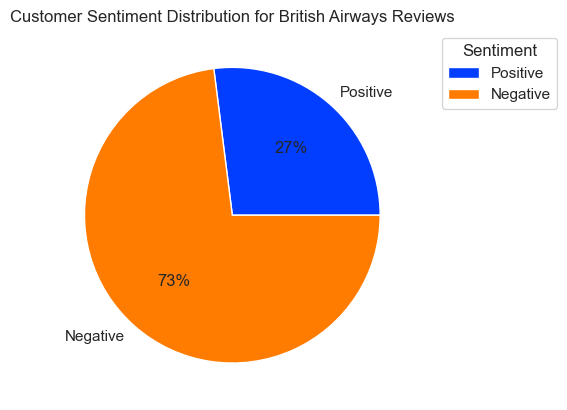

In [124]:
#Visualizing Customer Sentiment Distribution with a Pie Chart

data = [0.27, 0.73]
keys = ['Positive', 'Negative']

palette_color = seaborn.color_palette('bright')

# plotting data on chart
plt.pie(data, labels=keys, colors=palette_color, autopct='%.0f%%')
plt.title("Customer Sentiment Distribution for British Airways Reviews")

# Adding legend
plt.legend(title="Sentiment", loc="upper right", labels=keys, bbox_to_anchor=(1.4, 1))

# displaying chart
plt.show()


**Conclusion:**



Based on an analysis of 900 reviews, British Airways received a customer sentiment distribution with 73% expressing negativity and 27% showing positivity. The feedback underscores a varied range of sentiments among customers regarding their experiences.

##### Just for analysis

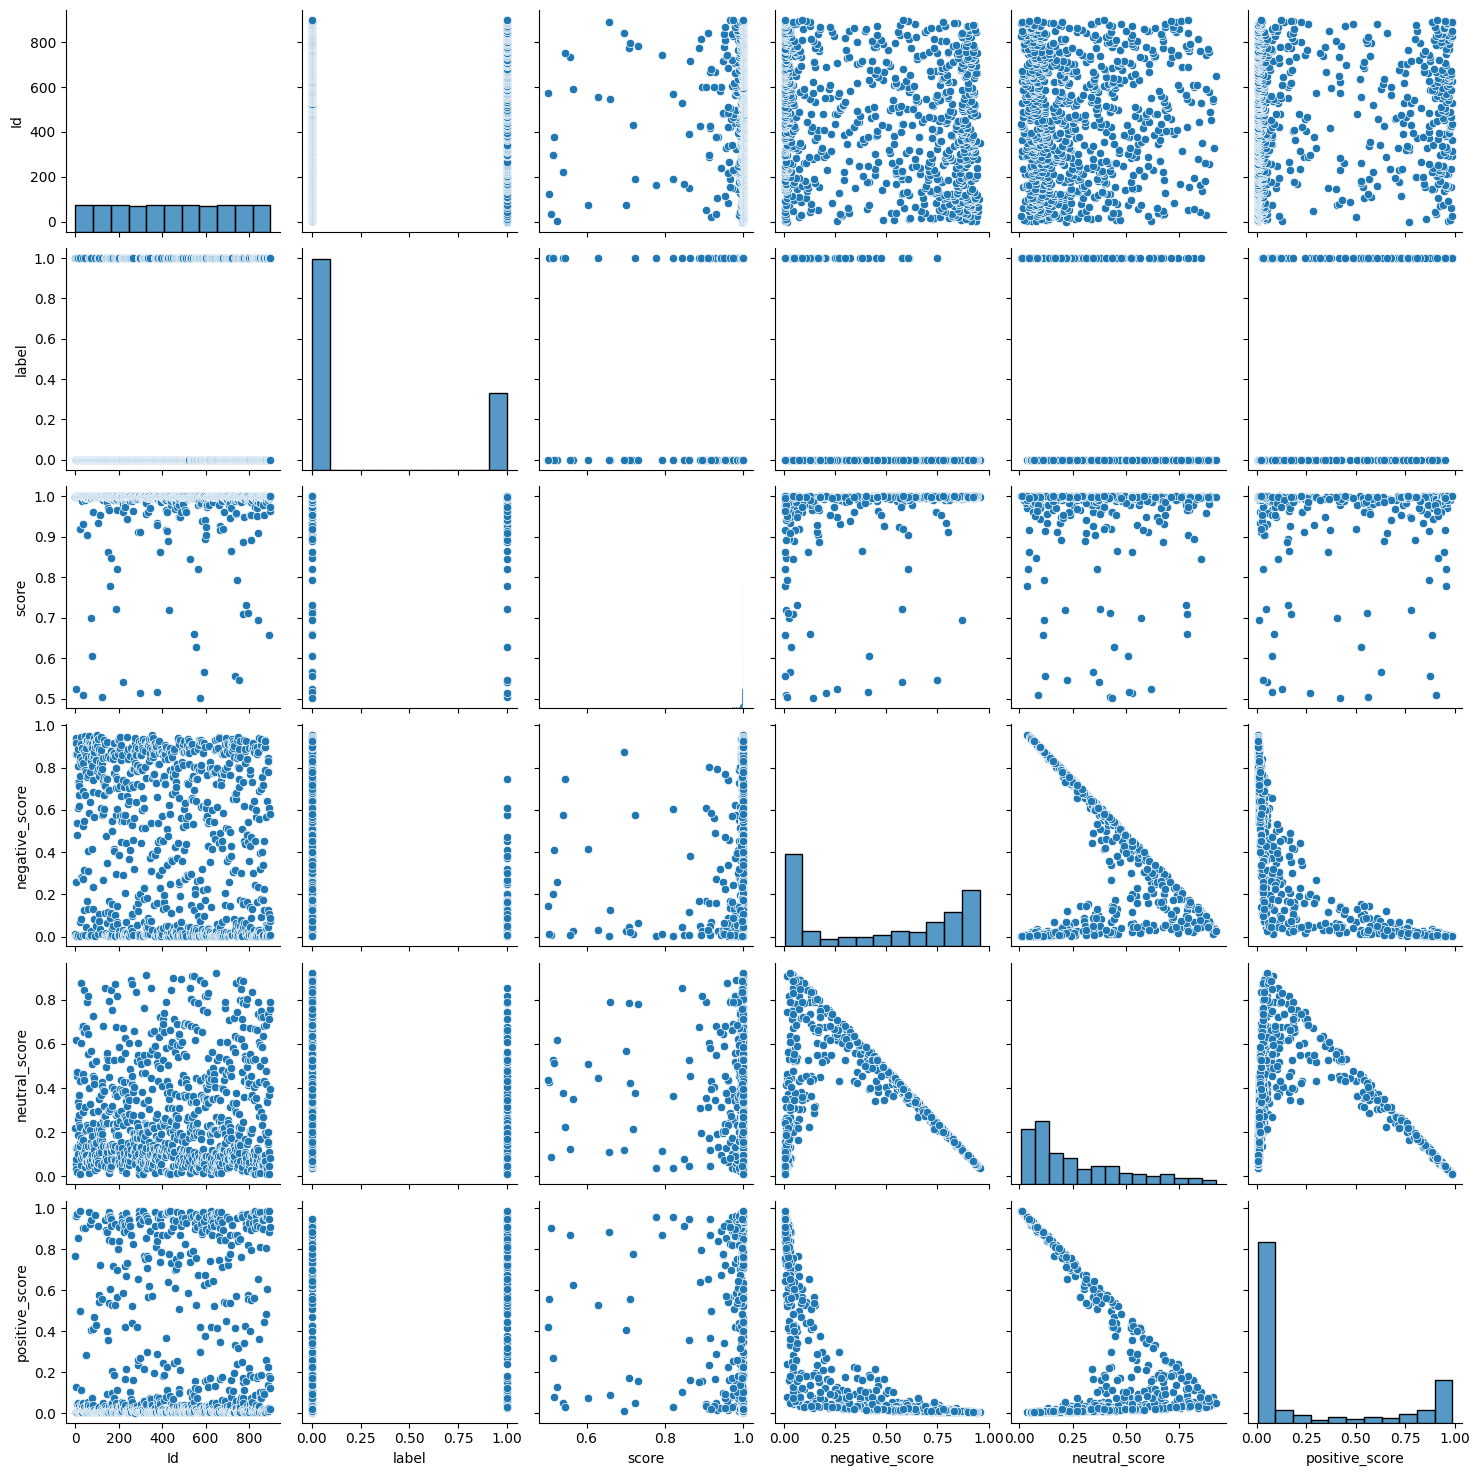

In [91]:
sns.pairplot(final_df)

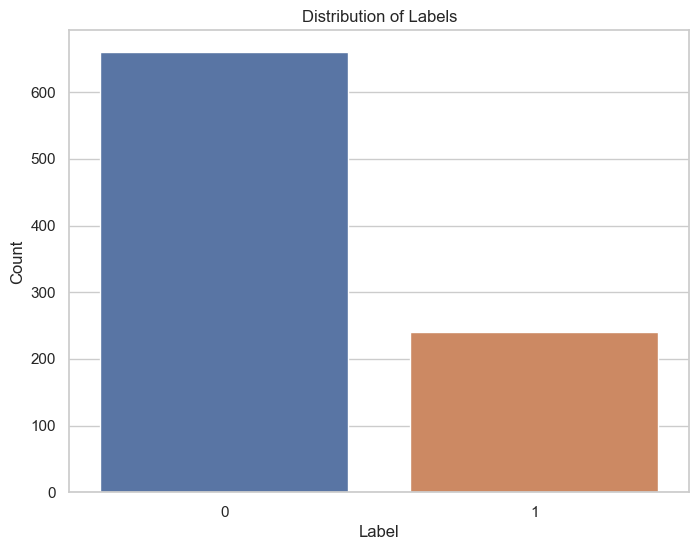

In [108]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming final_df has a "label" column with categorical values
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.countplot(data=final_df, x="label")

plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Distribution of Labels")
plt.show()


In [110]:
pos_review = final_df[final_df["label"] == 1]
neg_review = final_df[final_df["label"] == 0]

##### Saved Postive and Negative reviews for further analysis

In [111]:
pos_review.to_csv("BriAri_pos_review.csv")

In [112]:
neg_review.to_csv("BriAri_neg_review.csv")